In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import sklearn as sklearn
import re
import statsmodels.api as sm
import geoplot as gplt
import geopandas as gpd
from scipy.cluster.hierarchy import dendrogram, linkage

def refresh_dico(Name,Code,df):
    dic = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dic[i[1][Name]] = i[1][Code]
    return (dic)

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    return(gdf)

def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64))/np.log10(df_norm.astype(np.float64).max()))

#geoplot à utiliser das le cas d'une base avec des années (on a donc année et indic sur les lignes et années en colonnes)

def geo_plot (df,indic,annee,Titre = None,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            print(i +' n\'a aucun équivalent dans la table des données')
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    if norm :
        gdf[annee] = log_norm(gdf[annee])
        
    gplt.choropleth(gdf,
                hue = annee,
                cmap = couleur,
                legend=True,
                ax=ax)
    plt.show()

#Dans le cas d'un dataframe classique avec des Country code et des pays : 

def geo_plot_clas (df,indic,Discrete = False,Titre = None,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe (ici on utilise df1 pour avoir l'équivalence entre Country code et Country name)
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df1)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            print(i +' n\'a aucun équivalent dans la table des données')
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)
    
    gdf = create_gdf(df[['Country Code',indic]],map_monde)
    if norm :
        gdf[indic] = log_norm(gdf[indic])
    if Discrete :
        gplt.choropleth(gdf,
                    hue = indic,
                    cmap = couleur,
                    scheme = None,
                    ax=ax)
    else : 
        gplt.choropleth(gdf,
                    hue = indic,
                    cmap = couleur,
                    legend=True,
                    ax=ax)
    plt.show()
    

In [206]:
df1 = pd.read_csv("Complete_Data.csv")
df1 = df1.set_index('Pays_indic')
dic_code = refresh_dico('Country Code','Country Name',df1)

On crée ici une liste des codes de pays, et un dictionnaire avec le nom des variables

In [178]:
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

dic = {}
dic['pib'] = '_GDP (current US$)'
dic['pib_hab'] = '_GDP (current US$) par Tete'
dic['pib_growth'] = '_GDP growth (annual %)'
dic['pib_hab_growth'] = '_Croissance_GDP (current US$) par Tete (pourcent)'
dic['pop'] = '_Population, total'
dic['ges'] = '_Émissions totales de GES (kt d’équivalent CO2)'
dic['ges_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) (pourcent)	'
dic['ges_hab'] = '_Émissions totales de GES (kt d’équivalent CO2) par Tete'
dic['ges_hab_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)'
dic['industry'] = '_Industry (including construction), value added (% of GDP)'
dic['agr'] = '_Agriculture, forestry, and fishing, value added (% of GDP)'
dic['clean_nrj'] = '_Alternative and nuclear energy (% of total energy use)'
dic['nrj_hab'] = '_Energy use (kg of oil equivalent per capita)'
dic['nrj_hab_growth'] = '_Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'

On va chercher à créer la base avec les données qui nous intéressent pour la modélisation

In [179]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            coef = results.params[1]

            return coef, r2
    
    else : return
    
def get_coeff (regresse, regresseur) :    
    dico = {}
    for code in code_list:
        dico[code] = regress(code, regresse, regresseur)
        if dico[code] == None:
            dico.pop(code)

    regress_df = pd.DataFrame(dico.values(), dico.keys(), ['Coefficient de ' + regresse + ' sur ' + regresseur,
                                                         'R2 de ' + regresse + ' sur ' + regresseur])
    return regress_df


def get_2000(var):
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :
            dic[country_code] = df1.loc[country_code + var][23]
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['2000' + var])
    
    return(temp_df)

def get_average_growth_rate(var) :
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :    
            values = list(df1.loc[country_code + var][3:])
            values = [x for x in values if ~np.isnan(x)]
            initial_value = values[0]
            final_value = values[len(values)-1]
            variation_rate = (100 * ((final_value / initial_value))**(1/len(values))) - 100
            if variation_rate != np.inf :
                dic[country_code] = variation_rate
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['Average Growth Rate' + var])
    
    return(temp_df)

In [180]:
data = get_average_growth_rate(dic['pib_hab'])

data_list = [get_average_growth_rate(dic['agr']), get_average_growth_rate(dic['industry']), 
            get_average_growth_rate(dic['ges_hab']), get_average_growth_rate(dic['clean_nrj']),
            get_average_growth_rate(dic['nrj_hab']), 
            get_2000(dic['pib_hab']), get_2000(dic['agr']), get_2000(dic['industry']),
            get_2000(dic['ges_hab']), get_2000(dic['clean_nrj']), get_2000(dic['nrj_hab']), 
            get_coeff(dic['pib_hab'], dic['ges_hab']), get_coeff(dic['pib_hab_growth'], dic['ges_hab_growth']),
            get_coeff(dic['pib_hab'], dic['nrj_hab']), get_coeff(dic['pib_hab_growth'], dic['nrj_hab_growth'])]
for i in data_list :
    data = data.merge(i, how = 'outer', left_index = True, right_index = True)


C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


In [181]:
data.shape

(168, 20)

In [182]:
test = data.dropna(axis = 0)
test.shape

(60, 20)

In [183]:
test2 = pd.DataFrame()
for i in test.columns :
    test2[i] = preprocessing.scale(test[i])
test2.index = test.index

In [192]:
iner = []
k=3
#for k in range(2,50):
result = pd.DataFrame()
result=test2.copy()
centroid, result['Cluster'], inertie = sklearn.cluster.k_means(test2, k)
#nb_gens_cluster = []
#nb_gens = len(result.index)
#iner_inter = 0
#for i in range(0,k-1):
#    result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
#    result.where(result['Cluster'] == i).dropna()
#    nb_gens_cluster.append(len(result.where(result['Cluster'] == i).dropna().index))
#    iner_inter += (nb_gens_cluster[i]/nb_gens) *np.linalg.norm(centroid[i],ord =2)
#iner.append(inertie)
#plt.plot(np.linspace(2,50,num=49),iner)
#plt.show()

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

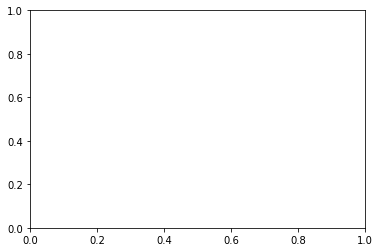

In [158]:
plt.plot(np.linspace(2,4,num=3),iner[:3])
plt.show()

In [193]:
for i in range(0,k-1):
    result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
    #result.where(result['Cluster'] == i).dropna() = pour sélectionner toutes les lignes d'un certain centroide (i)

In [186]:
t = np.linspace(1,20,num=20)
PCA = sklearn.decomposition.PCA(2)
PCA.fit(test2)
print(PCA.singular_values_)
print(PCA.explained_variance_ratio_*100)
test3 = PCA.transform(test2)
#plt.plot(t,PCA.explained_variance_ratio_*100)
#plt.show()

[16.07102224 14.89548032]
[21.52314631 18.48961116]


In [187]:
result_ACP = pd.DataFrame(test3)
result_ACP.head()
result_ACP.index = result[:-k+1].index
result_ACP['Cluster'] = result['Cluster'][:-k+1]

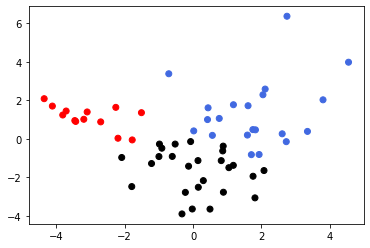

In [188]:
colormap = np.array(['black','red','royalblue','forestgreen','maroon','gold','darkgoldenrod','deeppink','mediumturquoise','orange','firebrick','silver'])
plt.scatter(result_ACP[0].to_numpy(),result_ACP[1].to_numpy(),c = colormap[result_ACP['Cluster'].astype(int).to_numpy()])
plt.show()

In [189]:
hierarc = sklearn.cluster.AgglomerativeClustering(4).fit(test2)

In [194]:
result

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,...,2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),Cluster
ARG,-0.384622,1.809802,-1.192836,0.000800,-0.252713,-0.067062,0.057029,-0.760693,-0.325845,0.090622,...,0.043128,-0.017323,-0.860655,-0.098446,0.652243,-0.265937,0.357991,-0.449523,0.322295,1.0
AUS,0.213912,-0.087300,-0.268703,0.215416,-0.185377,-0.430516,1.406798,-0.907959,-0.459920,5.458737,...,2.479956,0.074283,-0.940273,-1.487860,-0.143743,-0.610550,-0.386128,-0.424265,-0.267486,0.0
AUT,-0.017205,-0.792301,-0.423960,0.044983,-0.293376,-0.281403,1.685541,-1.046821,-0.098430,0.241203,...,1.208632,-0.033838,0.650572,-0.103116,-0.213786,-0.518509,0.794002,-0.392287,-0.439966,0.0
BGD,0.846895,-0.113047,1.074063,-0.301885,-1.403359,1.008988,-0.647270,0.941221,-0.693784,-0.805590,...,-0.892768,-0.180188,-0.582006,-0.088379,-0.505191,0.792941,1.349443,-0.644120,-0.790599,1.0
BGR,-0.110381,-1.086551,-1.891386,-0.638249,0.640358,-1.323886,-0.531030,-0.167175,-0.635511,-0.009752,...,0.415801,-0.153115,-1.066484,0.066866,1.713635,-1.291516,-1.699225,0.371588,1.500035,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,0.115409,1.475364,-0.692993,-0.362731,0.210302,-0.587043,-0.219865,-0.831166,1.697920,0.250046,...,0.318927,-0.107938,-0.396112,-0.304743,-0.707295,-0.487571,-0.092084,-0.125839,-0.433783,1.0
VNM,1.957669,-0.564797,0.782695,1.371988,1.260330,1.384164,-0.649972,1.112603,0.738871,-0.705595,...,-0.759999,0.641343,1.298589,-0.285876,-0.709754,1.975912,1.107724,-0.581455,-0.099218,2.0
ZMB,-1.294486,-1.297221,0.332118,-0.617625,-0.834248,-1.217016,-0.654262,0.321493,-0.598166,2.231648,...,-0.612589,-0.705914,-1.174418,-1.578412,-0.226148,-1.147764,-1.673162,-0.518591,2.115445,1.0
Centroid 0,-0.034975,-0.418368,-0.789352,-0.485940,0.378634,-0.778041,1.524533,-0.850549,-0.327161,0.718198,...,1.543237,-0.074456,0.071530,-0.147416,0.084025,-0.739022,-0.827521,-0.337916,-0.122619,0.0


In [1]:
hierarc = linkage(test2.drop('Country Code'),method='ward',metric='euclidean')

fig = plt.subplots(figsize=(20,10))
dendrogram(hierarc, labels=test2.index, orientation='top', color_threshold=1000, leaf_font_size=10) 
plt.title("Sentier de croissance de l'économie", fontsize=30)

plt.show()



NameError: name 'linkage' is not defined

### Implémentation des cartes :

In [114]:
df_car = pd.read_csv('Complete_data.csv')
df_car = df_car.set_index('Pays_indic')

Afghanistan n'a aucun équivalent dans la table des données
Kosovo n'a aucun équivalent dans la table des données
Cambodia n'a aucun équivalent dans la table des données
East Timor n'a aucun équivalent dans la table des données
Taiwan n'a aucun équivalent dans la table des données
Eritrea n'a aucun équivalent dans la table des données
Liberia n'a aucun équivalent dans la table des données
Western Sahara n'a aucun équivalent dans la table des données
South Sudan n'a aucun équivalent dans la table des données
Somalia n'a aucun équivalent dans la table des données
Bosnia and Herzegovina n'a aucun équivalent dans la table des données
Estonia n'a aucun équivalent dans la table des données
Lithuania n'a aucun équivalent dans la table des données
Croatia n'a aucun équivalent dans la table des données
Montenegro n'a aucun équivalent dans la table des données
Moldova n'a aucun équivalent dans la table des données
Macedonia n'a aucun équivalent dans la table des données
Republic of Serbia n'a auc

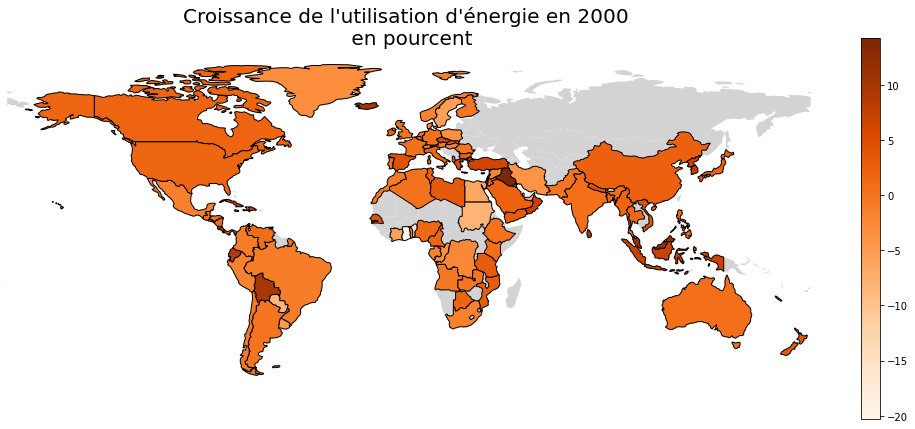

In [144]:
dic_pays = refresh_dico('Country Name','Country Code',df_car)
geo_plot (df_car,'Croissance_Energy use \(kg of oil equivalent per capita\) \(pourcent\)','2000','Croissance de l\'utilisation d\'énergie en 2000 \n en pourcent',couleur = 'Oranges',norm=False)

Afghanistan n'a aucun équivalent dans la table des données
Kosovo n'a aucun équivalent dans la table des données
Cambodia n'a aucun équivalent dans la table des données
East Timor n'a aucun équivalent dans la table des données
Taiwan n'a aucun équivalent dans la table des données
Eritrea n'a aucun équivalent dans la table des données
Liberia n'a aucun équivalent dans la table des données
Western Sahara n'a aucun équivalent dans la table des données
South Sudan n'a aucun équivalent dans la table des données
Somalia n'a aucun équivalent dans la table des données
Bosnia and Herzegovina n'a aucun équivalent dans la table des données
Estonia n'a aucun équivalent dans la table des données
Lithuania n'a aucun équivalent dans la table des données
Croatia n'a aucun équivalent dans la table des données
Montenegro n'a aucun équivalent dans la table des données
Moldova n'a aucun équivalent dans la table des données
Macedonia n'a aucun équivalent dans la table des données
Republic of Serbia n'a auc

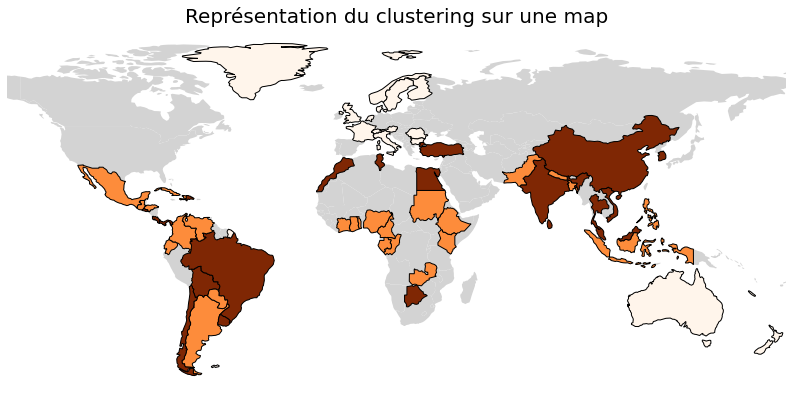

In [258]:
test2['Country Code'] = test2.index
geo_plot_clas (result,'Cluster',Discrete = True ,Titre = 'Représentation du clustering sur une map',couleur = 'Oranges',norm=False)

In [238]:
result['Cluster']

ARG           1.0
AUS           0.0
AUT           0.0
BGD           1.0
BGR           0.0
             ... 
VEN           1.0
VNM           2.0
ZMB           1.0
Centroid 0    0.0
Centroid 1    1.0
Name: Cluster, Length: 62, dtype: float64

In [246]:
result

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,...,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),Cluster,Country Code,Country Name
ARG,-0.384622,1.809802,-1.192836,0.000800,-0.252713,-0.067062,0.057029,-0.760693,-0.325845,0.090622,...,-0.860655,-0.098446,0.652243,-0.265937,0.357991,-0.449523,0.322295,1.0,ARG,NaN
AUS,0.213912,-0.087300,-0.268703,0.215416,-0.185377,-0.430516,1.406798,-0.907959,-0.459920,5.458737,...,-0.940273,-1.487860,-0.143743,-0.610550,-0.386128,-0.424265,-0.267486,0.0,AUS,NaN
AUT,-0.017205,-0.792301,-0.423960,0.044983,-0.293376,-0.281403,1.685541,-1.046821,-0.098430,0.241203,...,0.650572,-0.103116,-0.213786,-0.518509,0.794002,-0.392287,-0.439966,0.0,AUT,NaN
BGD,0.846895,-0.113047,1.074063,-0.301885,-1.403359,1.008988,-0.647270,0.941221,-0.693784,-0.805590,...,-0.582006,-0.088379,-0.505191,0.792941,1.349443,-0.644120,-0.790599,1.0,BGD,NaN
BGR,-0.110381,-1.086551,-1.891386,-0.638249,0.640358,-1.323886,-0.531030,-0.167175,-0.635511,-0.009752,...,-1.066484,0.066866,1.713635,-1.291516,-1.699225,0.371588,1.500035,0.0,BGR,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,0.115409,1.475364,-0.692993,-0.362731,0.210302,-0.587043,-0.219865,-0.831166,1.697920,0.250046,...,-0.396112,-0.304743,-0.707295,-0.487571,-0.092084,-0.125839,-0.433783,1.0,VEN,NaN
VNM,1.957669,-0.564797,0.782695,1.371988,1.260330,1.384164,-0.649972,1.112603,0.738871,-0.705595,...,1.298589,-0.285876,-0.709754,1.975912,1.107724,-0.581455,-0.099218,2.0,VNM,NaN
ZMB,-1.294486,-1.297221,0.332118,-0.617625,-0.834248,-1.217016,-0.654262,0.321493,-0.598166,2.231648,...,-1.174418,-1.578412,-0.226148,-1.147764,-1.673162,-0.518591,2.115445,1.0,ZMB,NaN
Centroid 0,-0.034975,-0.418368,-0.789352,-0.485940,0.378634,-0.778041,1.524533,-0.850549,-0.327161,0.718198,...,0.071530,-0.147416,0.084025,-0.739022,-0.827521,-0.337916,-0.122619,0.0,Centroid 0,NaN


In [253]:
result[['Country Code','Cluster']]

,Country Code,Cluster
ARG,ARG,1.0
AUS,AUS,0.0
AUT,AUT,0.0
BGD,BGD,1.0
BGR,BGR,0.0
...,...,...
VEN,VEN,1.0
VNM,VNM,2.0
ZMB,ZMB,1.0
Centroid 0,Centroid 0,0.0
